In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
!unzip /content/gdrive/MyDrive/Colab_Notebooks/graph_road_extraction/relational-fusion-networks.zip

Archive:  /content/gdrive/MyDrive/Colab_Notebooks/graph_road_extraction/relational-fusion-networks.zip
  inflating: Pipfile                 
  inflating: Pipfile.lock            
  inflating: README.md               
  inflating: requirements.txt        
  inflating: Tutorial.ipynb          
   creating: .ipynb_checkpoints/
   creating: rfn/
   creating: rfn/factory_functions/
  inflating: rfn/factory_functions/.__init__.py.swp  
  inflating: rfn/factory_functions/data_types.py  
  inflating: rfn/factory_functions/factory_functions.py  
  inflating: rfn/factory_functions/__init__.py  
  inflating: rfn/layer.py            
  inflating: rfn/network.py          
   creating: rfn/relational_fusion/
  inflating: rfn/relational_fusion/aggregators.py  
  inflating: rfn/relational_fusion/fusion_functions.py  
  inflating: rfn/relational_fusion/normalizers.py  
  inflating: rfn/relational_fusion/relational_fusion.py  
  inflating: rfn/relational_fusion/utils.py  
  inflating: rfn/relational_fus

In [11]:
!pip install -r requirements.txt

     |████████████████████████████████| 13.1 MB 856 kB/s 
     |████████████████████████████████| 25.4 MB 41.7 MB/s 
     |████████████████████████████████| 1.7 MB 34.1 MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556008 sha256=4ec4528ecbebb25b436c4ce62fbdbf57077db3888a7b484598a71f38466fcdc6
  Stored in directory: /root/.cache/pip/wheels/44/e6/b8/4efaab31158e9e9ca9ed80b11f6b11130bac9a9672b3cbbeaf
Successfully built networkx
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfully uninstalled networkx-2.6.3
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(G, pos={}):
    if not pos:
        pos = nx.spring_layout(G)
    
    nx.draw_networkx_nodes(G, pos, node_size = 500)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, arrows=True)
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


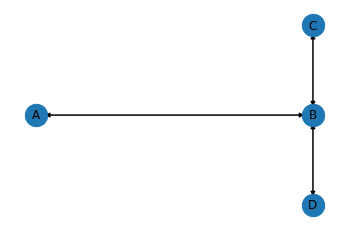

In [2]:
primal_graph = nx.DiGraph()

primal_graph.add_edge('A', 'B')
primal_graph.add_edge('B', 'A')

primal_graph.add_edge('B', 'C')
primal_graph.add_edge('C', 'B')

primal_graph.add_edge('B', 'D')
primal_graph.add_edge('D', 'B')

pos = {
    'A': (-1, 0),
    'B': (0, 0),
    'C': (0, 1),
    'D': (0, -1)}

plot_graph(primal_graph, pos)

/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


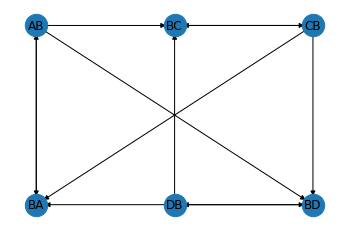

In [3]:
dual_graph = nx.DiGraph()
dual_graph.add_nodes_from(
    ''.join(edge)
    for edge in primal_graph.edges
)

for in_edge in primal_graph.edges():
    in_source, in_target = in_edge
    for out_target in primal_graph.successors(in_target):
        dual_graph.add_edge(
            ''.join(in_edge),
            ''.join([in_target, out_target])
        )

pos = {
    'AB': (0, 0),
    'BA': (0, -1),
    'BC': (1, 0),
    'DB': (1, -1),
    'CB': (2, 0),
    'BD': (2, -1)
}
plot_graph(dual_graph, pos)

In [4]:
from itertools import chain
from mxnet import ndarray as nd
import numpy as np
from pprint import pprint

In [5]:
def make_neighborhood_matrices(graph, node_indices, edge_indices,
                               is_dual=False, node_indices_primal=None):
    """
        Converts a graph into node and edge the required neighborhood matrices with asso

        Args:
            graph: A networkx primal or dual graph presentation of a road network.
            node_indices: A map from node objects in the graph to node indexes in
                          the output node neighborhood matrix N_node.
            edge_indices: A map from edge objects in the graph to edge indexes in
                          the output edge neighborhood matrix N_edge.
            is_dual: Boolean flag that indicates whether the graph is a dual graph.
            node_indices_primal: Must be supplied if is_dual is True.
                                 Maps node objects in the primal graph to node indexes in
                                 the common node neighborhood matrix N_common_node.
        Returns:
            N_node: A node adjacency list in matrix format.
                    The ith row contains the node indices of the nodes
                    in the neighborhood of the ith node. of the ith node.
            N_edge: A node adjacency list in matrix format.
                    The ith row contains the edge indices of the edges connecting the ith
                    node to its neighbors.
            N_mask: A matrix that indicates whether the jth entry in N_node or N_edge 
                    exists in the graph.
            N_common_node: Only returned if is_dual=True.
                           A common node is a node that is common to the two edges
                           connected by a between-edge. The ith row and jth column in 
                           this matrix contains the index of the common node that connects 
                           ith edge (a node in the dual graph) is connected to its jth neighbor.
            N_common_mask: Only returned if is_dual=True.
                           Similar to N_mask, N_common_mask indicates whether the jth entry in
                           N_common_node exists in the graph.
                           
        Raises:
            KeyError: Raises an exception.
    """
    assert not is_dual or is_dual and node_indices_primal is not None
    N_node = []
    N_edge = []
    
    nodes = sorted(
        list(graph.nodes()),
        key=lambda node: node_indices[node])

    for node in nodes:
        node_neighbors = []
        edge_neighbors = []
        
        predecessors = graph.predecessors(node)
        for neighbor in predecessors:
            node_neighbors.append(node_indices[neighbor])
            edge = (neighbor, node)
            edge_neighbors.append(edge_indices[edge])
        
        successors = graph.successors(node)
        for neighbor in successors:
            node_neighbors.append(node_indices[neighbor])
            edge = (node, neighbor)
            edge_neighbors.append(edge_indices[edge])

        assert len(node_neighbors) == len(edge_neighbors)
        N_node.append(node_neighbors)
        N_edge.append(edge_neighbors)
        
    N_node, N_mask = mask_neighborhoods(N_node)
    N_edge, _ = mask_neighborhoods(N_edge)
    N_mask = N_mask.reshape(*N_node.shape[:2], 1)

    if is_dual:
        N_common_node = [
            [node_indices_primal[edge[0][1]]]
             for edge in graph.edges()]
        N_common_node, N_common_node_mask = mask_neighborhoods(N_common_node, is_dual)
        N_common_node_mask = N_common_node_mask.reshape(*N_common_node.shape[:2], 1)
        return (N_node, N_edge, N_mask), (N_common_node, N_common_node_mask)
    else:
        return N_node, N_edge, N_mask

def mask_neighborhoods(neighborhoods_list, is_dual=False):
    max_no_neighbors = (
        max(len(n) for n in neighborhoods_list) if not is_dual
        else 1)
    shape = (len(neighborhoods_list), max_no_neighbors)

    neighborhoods_array = nd.zeros(
        shape=shape,
        dtype=np.int32)
    mask = nd.zeros(shape=shape)

    for idx, neighborhood in enumerate(neighborhoods_list):
        neighborhood_size = len(neighborhood)
        if neighborhood_size == 0:
            mask[:] = 1
            continue
        else:
            neighborhoods_array[idx][:neighborhood_size] = neighborhood
            mask[idx][:neighborhood_size] = 1

    return neighborhoods_array, mask

In [6]:
node_indices_primal = {node: idx for idx, node in enumerate(primal_graph.nodes())}
edge_indices_primal = {edge: idx for idx, edge in enumerate(primal_graph.edges())}

N_node_primal, N_edge_primal, N_mask_primal = edge_neighborhoods_primal = make_neighborhood_matrices(
    primal_graph, node_indices_primal, edge_indices_primal)
print('Neighborhood and Mask Matrices for the Primal Graph')
print('N_node', N_node_primal)
print('N_edge', N_edge_primal)
print('N_mask', N_mask_primal)

Neighborhood and Mask Matrices for the Primal Graph
N_node 
[[1 1 0 0 0 0]
 [0 2 3 0 2 3]
 [1 1 0 0 0 0]
 [1 1 0 0 0 0]]
<NDArray 4x6 @cpu(0)>
N_edge 
[[1 0 0 0 0 0]
 [0 4 5 1 2 3]
 [2 4 0 0 0 0]
 [3 5 0 0 0 0]]
<NDArray 4x6 @cpu(0)>
N_mask 
[[[1.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[1.]
  [1.]
  [1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]]

 [[1.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]]]
<NDArray 4x6x1 @cpu(0)>


In [7]:
node_indices_dual = {node: idx for idx, node in enumerate(dual_graph.nodes())}
edge_indices_dual = {edge: idx for idx, edge in enumerate(dual_graph.edges())}

(N_node_dual, N_edge_dual, N_mask_dual), (N_common_node, N_common_node_mask) = make_neighborhood_matrices(
    dual_graph, node_indices_dual, edge_indices_dual,
    is_dual=True, node_indices_primal=node_indices_primal)

pprint([(N_node_dual, N_edge_dual, N_mask_dual), (N_common_node, N_common_node_mask)])
print('Neighborhood and Mask Matrices for the Dual Graph')
print('N_node', N_node_dual)
print('N_edge', N_edge_dual)
print('N_mask', N_mask_dual)
print('N_common_node', N_common_node)
print('N_common_node_mask', N_common_node_mask)

[(
[[1 1 2 3]
 [0 4 5 0]
 [0 4 5 4]
 [0 4 5 5]
 [2 1 2 3]
 [3 1 2 3]]
<NDArray 6x4 @cpu(0)>,
  
[[ 3  0  1  2]
 [ 0  6  9  3]
 [ 1  7 10  4]
 [ 2  8 11  5]
 [ 4  6  7  8]
 [ 5  9 10 11]]
<NDArray 6x4 @cpu(0)>,
  
[[[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]]
<NDArray 6x4x1 @cpu(0)>),
 (
[[1]
 [1]
 [1]
 [0]
 [2]
 [3]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
<NDArray 12x1 @cpu(0)>,
  
[[[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[1.]]]
<NDArray 12x1x1 @cpu(0)>)]
Neighborhood and Mask Matrices for the Dual Graph
N_node 
[[1 1 2 3]
 [0 4 5 0]
 [0 4 5 4]
 [0 4 5 5]
 [2 1 2 3]
 [3 1 2 3]]
<NDArray 6x4 @cpu(0)>
N_edge 
[[ 3  0  1  2]
 [ 0  6  9  3]
 [ 1  7 10  4]
 [ 2  8 11  5]
 [ 4  6  7  8]
 [ 5  9 10 11]]
<NDArray 6x4 @cpu(0)>
N_mask 
[[[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.

In [8]:
X_V = nd.random.uniform(shape=(primal_graph.number_of_nodes(), 1))  # Node Features
X_E = nd.random.uniform(shape=(primal_graph.number_of_edges(), 3))  # Edge Features
X_B = nd.random.uniform(shape=(dual_graph.number_of_edges(), 2))    # Between-Edge Features
(X_V, X_E, X_B)

y = nd.random.uniform(shape=(primal_graph.number_of_edges(), 1))

In [15]:
from rfn.factory_functions import make_rfn, RFNLayerSpecification, FeatureInfo
from rfn.relational_fusion.normalizers import NoNormalization, L2Normalization
from mxnet.gluon.nn import ELU

In [16]:
input_feature_info = FeatureInfo.from_feature_matrices(X_V, X_E, X_B)
no_hidden_layers = 3
hidden_layer_specs = [
    RFNLayerSpecification(
        units=16,
        fusion='interactional',
        aggregator='attentional',
        normalization=L2Normalization(),
        activation=ELU()
    )
    for i in range(no_hidden_layers)
]

output_layer_spec = RFNLayerSpecification(
    units=1,
    fusion='additive',
    aggregator='non-attentional',
    normalization=NoNormalization(),
    activation='relu'
)

In [17]:
rfn = make_rfn(
    input_feature_info, hidden_layer_specs, output_layer_spec, output_mode='edge')

In [18]:
from mxnet import autograd
from mxnet.gluon import Trainer
from mxnet.gluon.loss import L2Loss

no_epochs = 10
learning_rate = 0.001
loss_function = L2Loss()
optimizer = 'adam'

rfn.initialize()
trainer = Trainer(rfn.collect_params(), optimizer, {'learning_rate': learning_rate})

for epoch in range(1, no_epochs + 1):
    with autograd.record():
        y_pred = rfn(X_V, X_E, X_B,
                N_node_primal, N_edge_primal, N_mask_primal, 
                N_node_dual, N_edge_dual, N_common_node, N_mask_dual)
        loss = loss_function(y_pred, y)
    loss.backward()
    trainer.step(batch_size=len(y))
    print(f'Loss at Epoch {epoch}: {loss.mean().asscalar()}')

Loss at Epoch 1: 0.19461780786514282
Loss at Epoch 2: 0.07784491777420044
Loss at Epoch 3: 0.05980579927563667
Loss at Epoch 4: 0.05288533866405487
Loss at Epoch 5: 0.04884670302271843
Loss at Epoch 6: 0.04577090963721275
Loss at Epoch 7: 0.0436779223382473
Loss at Epoch 8: 0.04182387515902519
Loss at Epoch 9: 0.03988155722618103
Loss at Epoch 10: 0.037888046354055405
